# Segmentation de la dentine
Données: Tomo_sain61_si_dej3

## Partie 1: Chargement des données et visualisation en 2D et en 3D

### 1- Configuration de  l'environnement de travail

In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider
import skimage as ski
import cv2
import scipy.ndimage as nd
import stackview

### 2- Chargement des métadonnées

In [2]:
# chargement des métadonnées
meta_file = "/home/experiences/grades/saras/Documents/DATA_SWING/01_processed_data/tomo_sain61_si_dej3/00_metadata/TIFF_delta_FBP_ram-lak_freqscl_1.00_cutoffs.txt"

#meta_file = "/home/experiences/grades/saras/DATA/Data_Swing/tomo_sain61_si_dej/TIFF_delta_FBP_ram-lak_freqscl_1.00_cutoffs.txt"
metadata = {}
with open(meta_file, "r") as file_in:
    for line in file_in:
        lines = line.split()
        if lines[1]== "Conversion":
            break
        metadata[lines[1]]= float(lines[-1])
 
print(metadata)
type(metadata)


{'low_cutoff': -4.25499e-06, 'high_cutoff': 1.613402e-05, 'factor': 0.0008829678, 'pixel': 2.793424e-08, 'factor_edensity': 92837.8}


dict

### 3- Chargement des données en 2D 

In [3]:
# Charger le chemin des images
raw_dir = "/home/experiences/grades/saras/Documents/DATA_SWING/01_processed_data/tomo_sain61_si_dej3/02_crop_data/crop_data_2d/"
output_dir= "/home/experiences/grades/saras/Documents/DATA_SWING/01_processed_data/tomo_sain61_si_dej3/03_watershed_2d/
images = sorted([img for img in os.listdir(raw_dir) if img.endswith(".tif")])
 
# Vérifier le trie des images en affichant les 5 premières images
print("premières images triées", images[:5])

# Charger les images dans un stack en 2D
stack_2d = np.array([ski.io.imread(os.path.join(raw_dir, img)) for img in images])

# Visualisation interactive avec stackview
stackview.slice(stack_2d)

premières images triées ['tomo_delta_sain61_si_dej3_S03477_to_S04276_FBP_ram-lak_freqscl_1.00_0001.tif', 'tomo_delta_sain61_si_dej3_S03477_to_S04276_FBP_ram-lak_freqscl_1.00_0002.tif', 'tomo_delta_sain61_si_dej3_S03477_to_S04276_FBP_ram-lak_freqscl_1.00_0003.tif', 'tomo_delta_sain61_si_dej3_S03477_to_S04276_FBP_ram-lak_freqscl_1.00_0004.tif', 'tomo_delta_sain61_si_dej3_S03477_to_S04276_FBP_ram-lak_freqscl_1.00_0005.tif']


### 4- Extraire une seule image du stack
Cette partie va permettre de valider le workflow avant de lancer le scripts sur le stack 3D. 

tomo_delta_sain61_si_dej3_S03477_to_S04276_FBP_ram-lak_freqscl_1.00_0401.tif


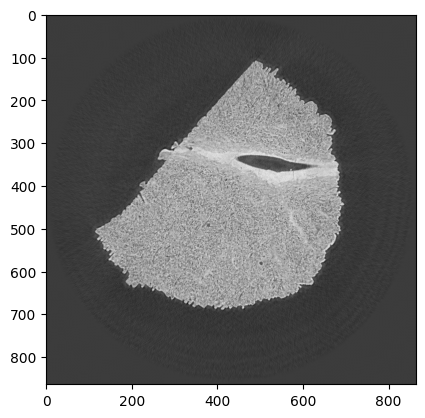

In [4]:
# Extraire l'image 400
img = images[400]
print(img)

# Chargement de l'image 300
img = Image.open(os.path.join(raw_dir, img))

# Affichage de l'image 300
plt.imshow(img, cmap="gray")
plt.show()

In [5]:
# Convert to array
im_array = np.array(img)

### 5- Affichage de l'histogramme des intensités
A partir de cet histogramme, nous allons définir les seuils pour le watershed pour la suite. 

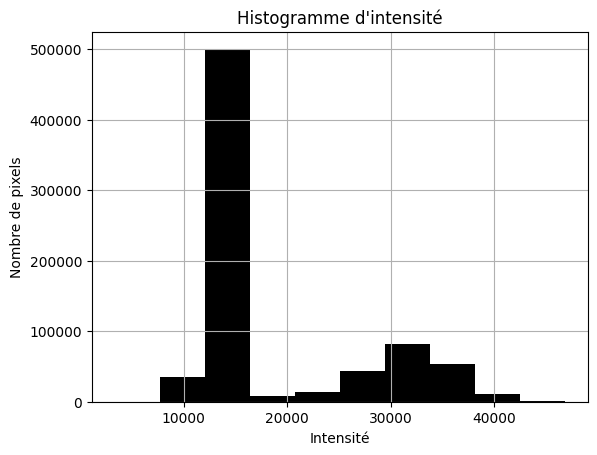

In [6]:
# Affichage de l'histogramme
plt.hist(im_array.ravel(), color='black')
plt.title("Histogramme d'intensité")
plt.xlabel("Intensité")
plt.ylabel("Nombre de pixels")
plt.grid(True)
plt.show()

## Partie 2 - Prétraitement des images

In [7]:
# Normalisation en 8 bits
img_norm = ((im_array - im_array.min()) / np.ptp(im_array)) * 255
img_norm = img_norm.astype(np.uint8)


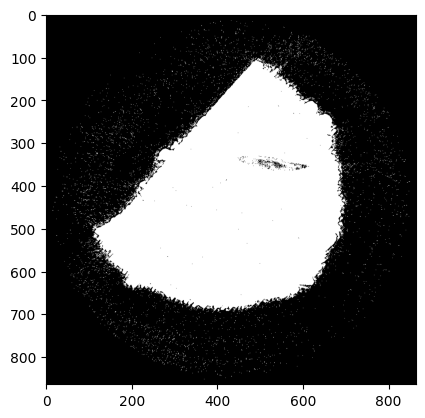

In [8]:
# Détection des contours avec le seuil de Yen
border = ski.filters.threshold_yen(img_norm)
border = img_norm > border
plt.imshow(border, cmap="gray")
plt.show()


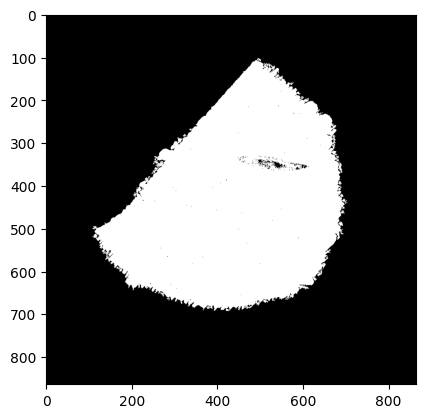

In [9]:
# Remove small objects
borderclean = ski.morphology.remove_small_objects(border)
plt.imshow(borderclean, cmap="gray")
plt.show()

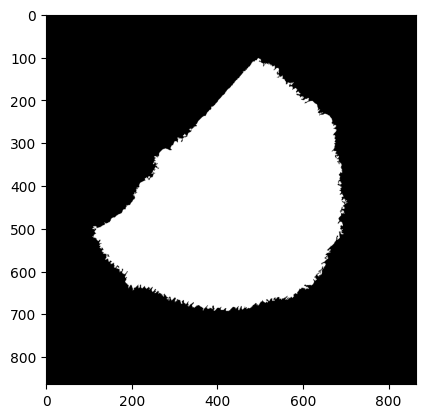

In [10]:
# Fill holes
borderfill = ski.morphology.area_closing(borderclean, area_threshold=100000)
plt.imshow(borderfill, cmap="gray")
plt.show()

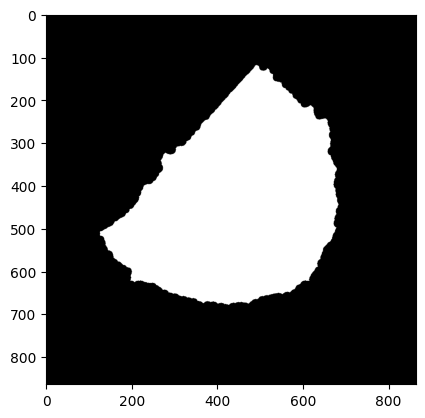

In [11]:
#Applique une érosion isotropique avec un rayon de 10 pixels, réduisant ainsi la taille des objets segmentés 
borderlow = ski.morphology.isotropic_erosion(borderfill, 10)
plt.imshow(borderlow, cmap="gray")
plt.show()

In [12]:
#Suppression des pixels en dehors du masque érodé
imclean = im_array.copy()
imclean[~borderlow] = 0


In [13]:
# 2. Création d'une image vide (0 partout) de la même taille que imclean
image_vide = np.zeros_like(imclean)


## Partie 3-  Watershed pour la segmentation de la lumière tubulaire

### 1- Définition des seuils pour le watershed

In [14]:
#Seuil: Ces seuils doivent être ajustés par rapport à l'histogramme de chaque jeu de données 
seuil_1 = 24000
seuil_2 = 0
seuil_3 = 22000

### 2- Création du masque binaire avec les seuils

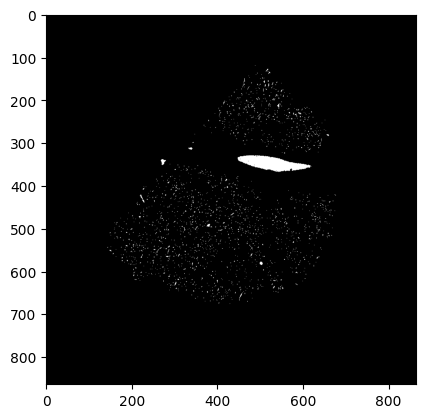

In [15]:
# Masque binaire avec les pixels [seuil_2 _ seuil2)]
masque = (imclean > seuil_2) & (imclean < seuil_3)
plt.imshow(masque, cmap="gray")
plt.show()

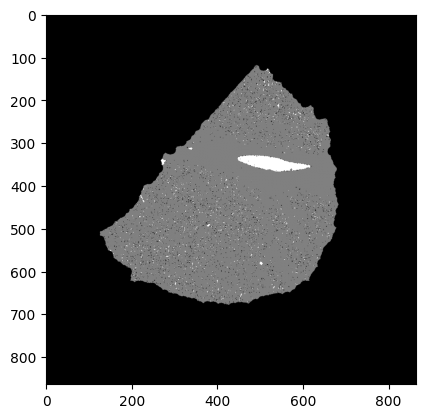

In [16]:
# remplissage de l'array avec les seuils
image_vide[masque] = 2
image_vide[imclean > seuil_1] = 1
image_vide[~borderlow] = 0
plt.imshow(image_vide, cmap="gray")
plt.show()

### 3- Watershed transformation

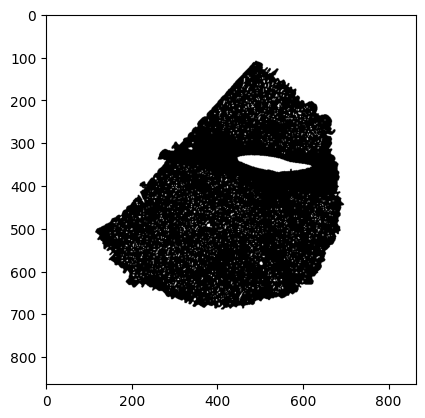

In [17]:
# Watershed
elem = ski.morphology.disk(5)
watershed_labels = ski.segmentation.watershed(ski.filters.sobel(ski.filters.gaussian(im_array,1)), image_vide)
plt.imshow(watershed_labels, cmap="gray")
plt.show()

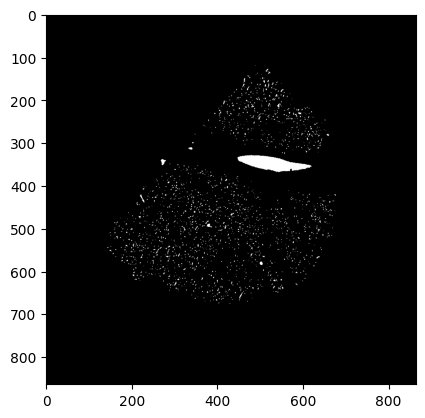

In [18]:
# Création des labels à partir du watershed
watershed_labels[watershed_labels == 1] = 0
watershed_labels[watershed_labels == 2] = 1
lumiere = borderlow & watershed_labels
plt.imshow(lumiere, cmap="gray")
plt.show()

## Partie 3-  Visualisation du résultats 

### Superposition entre masque lumière tubulaire et image d'origine

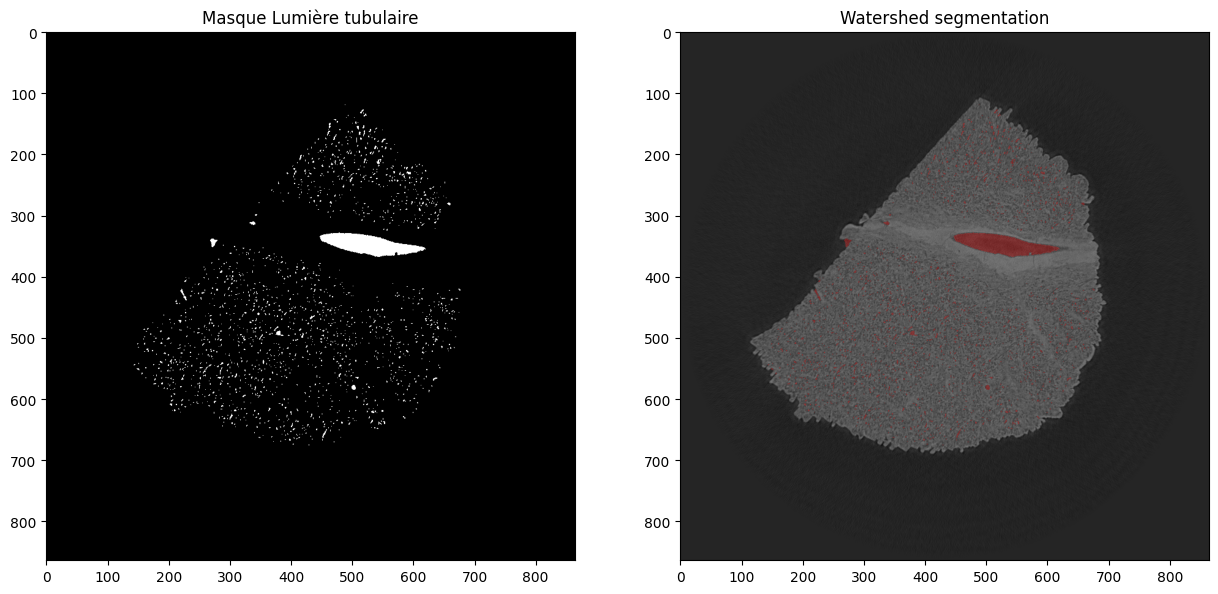

In [19]:
# Affichage du masque lumiere et de l'image d'origine
fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(lumiere, cmap="gray")
ax[0].set_title("Masque Lumière tubulaire")
ax[1].imshow(ski.color.label2rgb(lumiere, im_array), cmap="gray")
ax[1].set_title("Watershed segmentation")
plt.show()


In [46]:
print("borderfill min/max:", borderfill.min(), borderfill.max())
print("borderlow min/max:", borderlow.min(), borderlow.max())
print("lumiere min/max:", lumiere.min(), lumiere.max())

borderfill min/max: False True
borderlow min/max: False True
lumiere min/max: 0 1
